# Challenge Intermedio: Modelado con Spark ML

PÉREZ ROSAS LUIS ALFREDO MCD UDG 2025-B GRUPO 2

Este challenge lleva a los estudiantes un paso más allá en el uso de PySpark, implementando Spark ML para realizar un modelo predictivo basado en una gran base de datos.<BR>

Spark ML (Machine Learning) es la biblioteca de aprendizaje automático de Apache Spark, diseñada para manejar de manera eficiente y escalable grandes volúmenes de datos. 


## Objetivos

### 2.	Objetivo general:

Aplicar algoritmos de machine learning en grandes bases de datos utilizando Spark ML.

### 3.	Objetivo específico:

Descargar una base de datos desde UCI Machine Learning Repository, limpiarla, y entrenar un modelo predictivo de clasificación utilizando Spark ML.


1. Cargar un dataset público (recomendado: *Wine Quality* UCI) con Spark.
2. Realizar **EDA** con gráficos (histogramas, boxplots, correlación, distribución de la etiqueta).
3. Construir un **pipeline** (VectorAssembler + StandardScaler) y entrenar **al menos dos modelos** (LR, RF).
4. Evaluar con métricas y **gráficas** (ROC, PR, matriz de confusión, importancia de variables).
5. Realizar **búsqueda de hiperparámetros** con **CrossValidator**.


## Requisitos técnicos
- Spark 3.4+ con PySpark.
- Para graficar, usar `matplotlib` (una figura por gráfico, **sin** estilos o colores específicos).
- Para graficar desde Spark, convertir a pandas con `toPandas()` cuando sea necesario.


In [4]:
# === 1) Setup de Spark ===
from pyspark.sql import SparkSession

spark = (
    SparkSession.builder
    .appName("wine-quality-ml-v2")
    # .config("spark.driver.memory", "4g")  # opcional
    .getOrCreate()
)

spark


## Carga del dataset

###	Base de datos:

Base de datos: Wine Quality Dataset <br>
Plataforma: UCI Machine Learning Repository <br>
Instrucciones: Descargar y cargar los datos en Apache Spark para crear el modelo. <br>


> Usa el conjunto **Wine Quality** (red o white) del UCI Repository. Ajusta la ruta al CSV.


In [5]:
# === 2) Carga de datos ===
# Ajusta la ruta al archivo CSV (usa el separador ';' del dataset original)
# Ejemplo: path = "/dbfs/FileStore/winequality-red.csv" o path local si corres fuera de Databricks.
path = "data/winequality-red.csv"  # <-- CAMBIA ESTA RUTA
raw = spark.read.csv(path, header=True, inferSchema=True, sep=';')
raw.printSchema()
raw.show(10)

root
 |-- fixed acidity: double (nullable = true)
 |-- volatile acidity: double (nullable = true)
 |-- citric acid: double (nullable = true)
 |-- residual sugar: double (nullable = true)
 |-- chlorides: double (nullable = true)
 |-- free sulfur dioxide: double (nullable = true)
 |-- total sulfur dioxide: double (nullable = true)
 |-- density: double (nullable = true)
 |-- pH: double (nullable = true)
 |-- sulphates: double (nullable = true)
 |-- alcohol: double (nullable = true)
 |-- quality: integer (nullable = true)

+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+----+---------+-------+-------+
|fixed acidity|volatile acidity|citric acid|residual sugar|chlorides|free sulfur dioxide|total sulfur dioxide|density|  pH|sulphates|alcohol|quality|
+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+----+---------+-------+-------+
|          7.4|          

## Ingeniería de características y etiqueta binaria

Creamos `label = 1` si `quality >= 6`, de lo contrario `0`. (Puedes justificar otro umbral).


In [17]:
# === 3) Ingeniería de características y etiqueta ===
from pyspark.sql import functions as F

wine = raw.withColumn("label_quality_7_or_less", (F.col("quality") <= 7).cast("int"))
wine.select("quality", "label_quality_7_or_less").groupBy("label_quality_7_or_less").count().show()

+-----------------------+-----+
|label_quality_7_or_less|count|
+-----------------------+-----+
|                      1| 1581|
|                      0|   18|
+-----------------------+-----+



## EDA — Gráficas obligatorias

Para graficar, convertimos a pandas con `toPandas()`.
- Histogramas por variable numérica
- Boxplots
- Matriz de correlación
- Distribución de la etiqueta


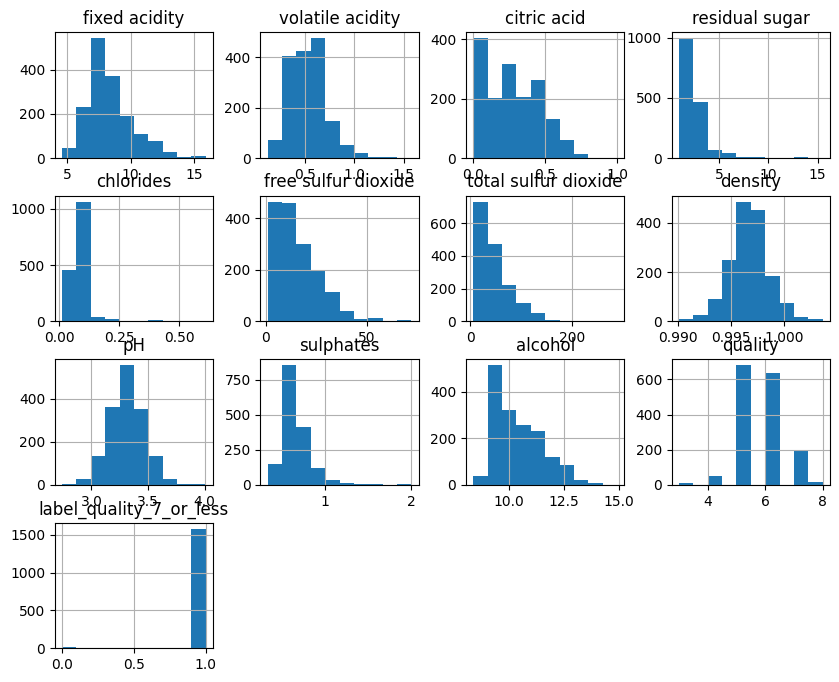

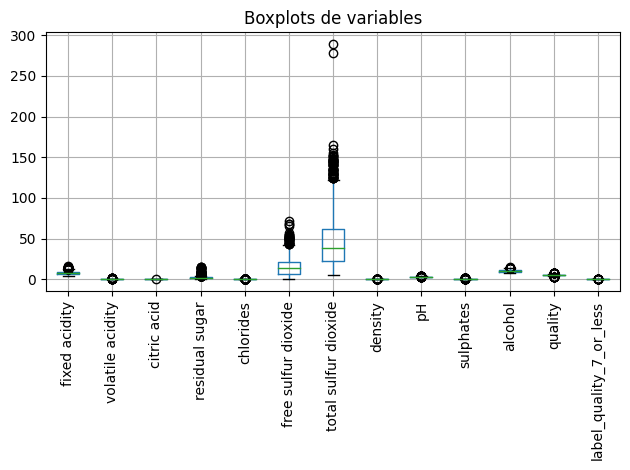

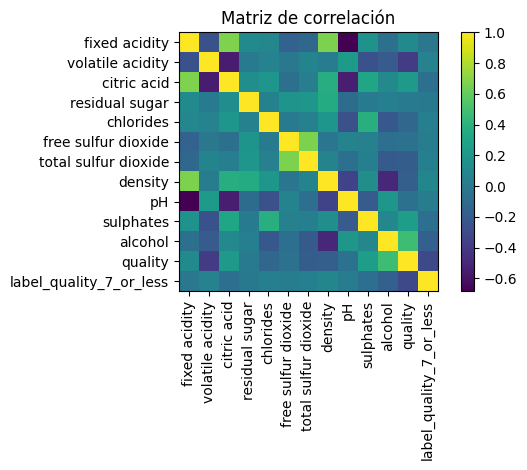

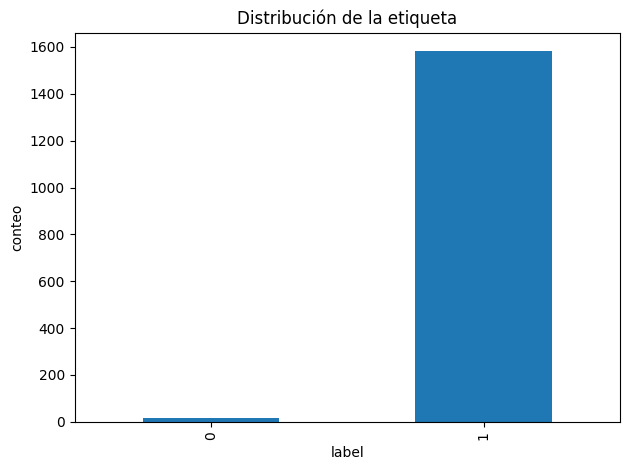

In [18]:
# === 4) EDA: Histogramas, Boxplots, Correlación, Distribución de etiqueta ===
import matplotlib.pyplot as plt

pdf = wine.toPandas()

# 4.1 Histogramas
ax = pdf.hist(figsize=(10, 8))
plt.show()

# 4.2 Boxplots
plt.figure()
pdf.boxplot(rot=90)
plt.title("Boxplots de variables")
plt.tight_layout()
plt.show()

# 4.3 Matriz de correlación (solo numéricas)
plt.figure()
corr = pdf.corr(numeric_only=True)
plt.imshow(corr, interpolation='nearest')
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.columns)), corr.columns)
plt.colorbar()
plt.title("Matriz de correlación")
plt.tight_layout()
plt.show()

# 4.4 Distribución de la etiqueta
plt.figure()
pdf['label_quality_7_or_less'].value_counts().sort_index().plot(kind='bar')
plt.title("Distribución de la etiqueta")
plt.xlabel("label")
plt.ylabel("conteo")
plt.tight_layout()
plt.show()

## Preparación de datos y split

Construiremos el vector de *features* y escalaremos con `StandardScaler`.


In [19]:
# === 5) Preparación de datos y split ===
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml import Pipeline

feature_cols = [c for c in wine.columns if c not in ['quality', 'label']]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features_raw")
scaler = StandardScaler(inputCol="features_raw", outputCol="features")

pipeline_prep = Pipeline(stages=[assembler, scaler])
prepared = pipeline_prep.fit(wine).transform(wine)

train, test = prepared.randomSplit([0.8, 0.2], seed=42)
train.count(), test.count()

(1324, 275)

## Modelado: Regresión Logística y Random Forest

Entrenamos y comparamos dos modelos base.


In [21]:
# === 6) Modelos base (LR y RF) ===
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier

lr = LogisticRegression(featuresCol="features", labelCol="label_quality_7_or_less")
rf = RandomForestClassifier(featuresCol="features", labelCol="label_quality_7_or_less", numTrees=200)

lr_model = lr.fit(train)
rf_model = rf.fit(train)

pred_lr = lr_model.transform(test)
pred_rf = rf_model.transform(test)

pred_lr.select("label_quality_7_or_less", "prediction", "probability").show(5, truncate=False)
pred_rf.select("label_quality_7_or_less", "prediction", "probability").show(5, truncate=False)

+-----------------------+----------+-----------------------------------------+
|label_quality_7_or_less|prediction|probability                              |
+-----------------------+----------+-----------------------------------------+
|1                      |1.0       |[8.789378497101344E-9,0.9999999912106216]|
|1                      |1.0       |[6.912826786101892E-9,0.9999999930871732]|
|1                      |1.0       |[6.72911090210378E-9,0.9999999932708891] |
|1                      |1.0       |[4.878229106892307E-9,0.9999999951217708]|
|1                      |1.0       |[8.857607431425726E-9,0.9999999911423926]|
+-----------------------+----------+-----------------------------------------+
only showing top 5 rows

+-----------------------+----------+-----------------------------------------+
|label_quality_7_or_less|prediction|probability                              |
+-----------------------+----------+-----------------------------------------+
|1                      |1.

## Evaluación inicial (AUC)

Calculamos el AUC para ambos modelos.<br>

 AUC significa "Area Under the Curve" (Área Bajo la Curva)<br>

 Los valores del AUC varían de 0.5 a 1.0: <br><br>
AUC = 1.0: Indica un rendimiento predictivo perfecto; el modelo puede separar perfectamente las clases positivas y negativas sin errores.<br>
AUC entre 0.8 y 0.9: Se considera un rendimiento excelente.<br>
AUC entre 0.7 y 0.8: Se considera un rendimiento aceptable.<br>
AUC = 0.5: Indica que el modelo no es mejor que una suposición aleatoria (azar) para distinguir entre las clases. 


In [23]:
# === 7) Evaluación (AUC) ===
from pyspark.ml.evaluation import BinaryClassificationEvaluator

evaluator = BinaryClassificationEvaluator(labelCol='label_quality_7_or_less', rawPredictionCol='rawPrediction')
auc_lr = evaluator.evaluate(pred_lr)
auc_rf = evaluator.evaluate(pred_rf)

print("AUC LR:", auc_lr)
print("AUC RF:", auc_rf)

AUC LR: 1.0
AUC RF: 1.0


## Curvas ROC y Precision-Recall (LR)

Usamos el `summary` del modelo de LR para graficar ROC y PR.
<br><BR>
La curva ROC (Receiver Operating Characteristic) es una herramienta gráfica utilizada para evaluar el rendimiento de los modelos de clasificación binaria, mientras que LR comúnmente se refiere a la regresión logística (Logistic Regression), que es un tipo de modelo que a menudo se evalúa con la curva ROC. 

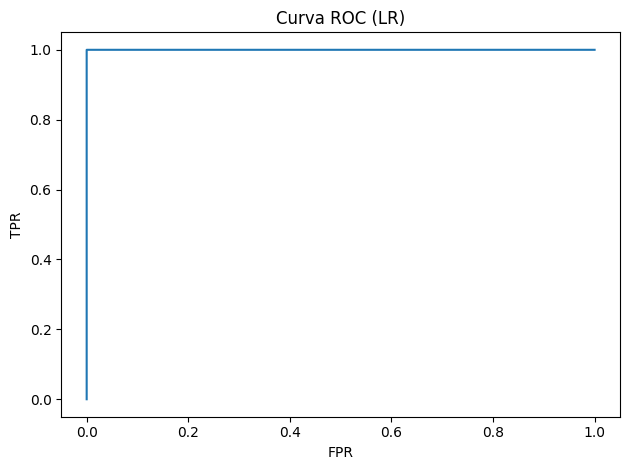

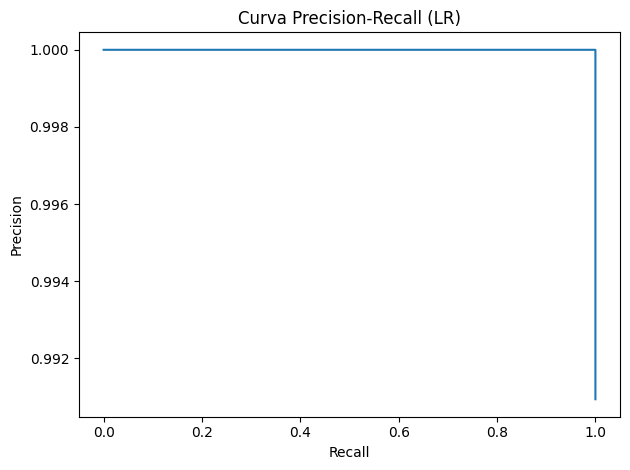

In [24]:
# === 8) Curvas ROC y PR (LR) ===
import matplotlib.pyplot as plt

train_summary = lr_model.summary
roc_df = train_summary.roc.toPandas()
pr_df = train_summary.pr.toPandas()

# ROC
plt.figure()
plt.plot(roc_df['FPR'], roc_df['TPR'])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('Curva ROC (LR)')
plt.tight_layout()
plt.show()

# PR
plt.figure()
plt.plot(pr_df['recall'], pr_df['precision'])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Curva Precision-Recall (LR)')
plt.tight_layout()
plt.show()

## Matriz de confusión (RF)

Convertimos a pandas para graficar.<br>

Una matriz de confusión es una tabla que se utiliza para evaluar el rendimiento de un modelo de clasificación en inteligencia artificial, como un modelo de Random Forest (RF). Permite visualizar y comparar los valores reales de los datos con los valores predichos por el modelo. 


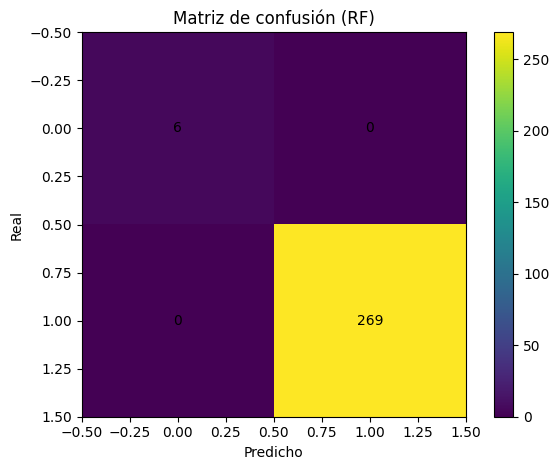

In [28]:
# === 9) Matriz de confusión (RF) ===
from sklearn.metrics import confusion_matrix
import numpy as np

preds_rf = pred_rf.select('prediction', 'label_quality_7_or_less').toPandas()
cm = confusion_matrix(preds_rf['label_quality_7_or_less'], preds_rf['prediction'])

plt.figure()
plt.imshow(cm, interpolation='nearest')
plt.title('Matriz de confusión (RF)')
plt.xlabel('Predicho')
plt.ylabel('Real')
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha='center', va='center')
plt.colorbar()
plt.tight_layout()
plt.show()

## Importancia de variables (RF)


In [29]:
# === 10) Importancia de variables (RF) ===
import pandas as pd
fi = pd.DataFrame({
    'feature': feature_cols,
    'importance': rf_model.featureImportances.toArray()
}).sort_values('importance', ascending=False)

fi.head(10)

,feature,importance
11,label_quality_7_or_less,0.760260
9,sulphates,0.036798
8,pH,0.027159
10,alcohol,0.026439
0,fixed acidity,0.023915
5,free sulfur dioxide,0.023185
7,density,0.022634
1,volatile acidity,0.021938
2,citric acid,0.017590
6,total sulfur dioxide,0.017585


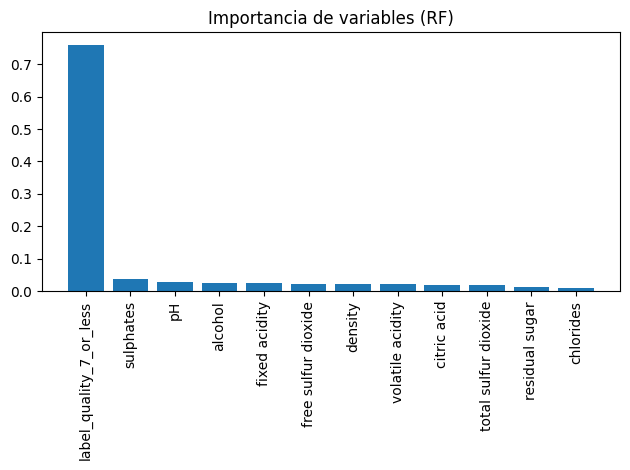

In [30]:
# Gráfico de importancia (una figura, sin estilos de color específicos)
import matplotlib.pyplot as plt

plt.figure()
plt.bar(fi['feature'], fi['importance'])
plt.xticks(rotation=90)
plt.title('Importancia de variables (RF)')
plt.tight_layout()
plt.show()

## Búsqueda de hiperparámetros + CrossValidator (RF)


In [32]:
# === 11) Cross-Validation (RF) ===
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

paramGrid = (ParamGridBuilder()
             .addGrid(rf.numTrees, [100, 200, 400])
             .addGrid(rf.maxDepth, [5, 10])
             .build())

cv = CrossValidator(
    estimator=rf,
    estimatorParamMaps=paramGrid,
    evaluator=BinaryClassificationEvaluator(labelCol='label_quality_7_or_less'),
    numFolds=3,
    parallelism=2
)

cv_model = cv.fit(train)
cv_pred = cv_model.bestModel.transform(test)
auc_cv = evaluator.evaluate(cv_pred)

print("AUC RF (CV):", auc_cv)
cv_model.bestModel

AUC RF (CV): 1.0


RandomForestClassificationModel: uid=RandomForestClassifier_da4a78fe678a, numTrees=100, numClasses=2, numFeatures=12

## Comparativa de modelos
Calcula métricas (Accuracy, Precision, Recall, F1) y compáralas.


In [34]:
# === 12) Comparativa de métricas ===
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def metrics_from_spark_pred(spark_pred_df):
    pdf_pred = spark_pred_df.select('label_quality_7_or_less', 'prediction').toPandas()
    acc = accuracy_score(pdf_pred['label_quality_7_or_less'], pdf_pred['prediction'])
    pre = precision_score(pdf_pred['label_quality_7_or_less'], pdf_pred['prediction'])
    rec = recall_score(pdf_pred['label_quality_7_or_less'], pdf_pred['prediction'])
    f1  = f1_score(pdf_pred['label_quality_7_or_less'], pdf_pred['prediction'])
    return acc, pre, rec, f1

acc_lr, pre_lr, rec_lr, f1_lr = metrics_from_spark_pred(pred_lr)
acc_rf, pre_rf, rec_rf, f1_rf = metrics_from_spark_pred(pred_rf)
acc_cv, pre_cv, rec_cv, f1_cv = metrics_from_spark_pred(cv_pred)

import pandas as pd
summary = pd.DataFrame({
    'modelo': ['LR', 'RF', 'RF (CV)'],
    'AUC':    [auc_lr, auc_rf, auc_cv],
    'Accuracy': [acc_lr, acc_rf, acc_cv],
    'Precision': [pre_lr, pre_rf, pre_cv],
    'Recall': [rec_lr, rec_rf, rec_cv],
    'F1': [f1_lr, f1_rf, f1_cv]
})
summary

,modelo,AUC,Accuracy,Precision,Recall,F1
0,LR,1.0,1.0,1.0,1.0,1.0
1,RF,1.0,1.0,1.0,1.0,1.0
2,RF (CV),1.0,1.0,1.0,1.0,1.0


## Conclusiones
- Compara resultados y justifica el modelo recomendado.
- Discute *trade-offs* (complejidad, interpretabilidad, rendimiento).
- (Opcional) Propuestas de mejora: balanceo de clases, más features, MLflow, explicabilidad.
